In [2]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [113]:
!pip install ephem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.3 MB/s eta 0:00:00


In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import spacy
import seaborn as sns
from transformers import pipeline
import matplotlib.pyplot as plt
import numpy as np
import ephem
import requests
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache
import time
from datetime import datetime
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

## Pre-Process

Focus on necessary data only

In [4]:
# Load datasets
df0 = pd.read_csv('7_8_all_emo_num.csv')

In [7]:
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    # Check if text is NaN (float) or None
    if isinstance(text, float) or text is None:
        return ""

    doc = nlp(text.lower().strip())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

df0["Assault_Description_Clean"] = df0["Assault Description"].apply(preprocess)
df0["Primary_Assault_Description_Clean"] = df0["Primary Assault Description"].apply(preprocess)
df0["Primary_Contributing_Factors_Clean"] = df0["Primary Contributing Factors"].apply(preprocess)
# Fill NA values with empty string and combine
df0["Combined_Description"] = df0["Primary_Assault_Description_Clean"].fillna('') + " " + df0["Assault_Description_Clean"].fillna('')
df0["Combined_Description"] = df0["Combined_Description"].str.strip()

In [25]:
df = df.set_axis(['date', 'aggressor', 'response', 'role', 'violence type', 'location', 'general location', 'severity', 'emotion', 'care', 'factor', 'description'], axis='columns')

In [29]:
df.head()

,date,aggressor,response,role,violence type,location,general location,severity,emotion,care,factor,description,Topic
0,1/9/2024,Patient,"Security Called, Law Enforcement Called, De-es...",Nurse,Physical Violence,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,24
1,1/9/2024,Patient,"Security Called, Law Enforcement Called, De-es...",Nurse,Verbal Abuse,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,24
2,1/9/2024,Patient,"Security Called, Law Enforcement Called, De-es...",Nurse,Physical Violence,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,24
3,1/9/2024,Patient,"Security Called, Law Enforcement Called, De-es...",Nurse,Verbal Abuse,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,24
4,2/6/2024,Patient,"Security Called, Law Enforcement Called, Physi...",Nurse,Physical Violence,ED/ER,Clinical Unit,0.0,0.0,NaN,alter mental status inpatient bed unavailable,grab pinching scratch hair pull kicking hit be...,26


In [20]:
df = df0.drop(columns=['Facility Type', 'Department/Office Incident Took Place',
                       'Split Roles', 'Occupational Category of Person Affected',
                       'Type of Violence',
                       'Primary Contributing Factors',
                       'Severity of Assault', 'General Severity Category',
                       'Assault Description', 'Assault_Description_Clean',
                       'Primary Assault Description', 'Primary_Assault_Description_Clean',
                       'Emotional and/ or Psychological Impact',
                       'Level of Care Needed'])

In [30]:
df['Topic'].value_counts()

,count
Topic,
-1,191
0,63
1,56
2,54
3,44
4,44
5,41
6,40
7,39


In [9]:
df0.to_csv('8_9.1_all_clean_factor.des.csv', index=False)

In [26]:
df.to_csv('8_9.2_all_necessary_only.des.csv', index=False)

## Semantic Analysis with BERTopic

In [55]:
df = pd.read_csv('8_9.2_all_necessary_only.des.csv')

In [63]:
df.head()

,date,aggressor,response,role,violence type,location,general location,severity,emotion,care,factor,description,role_encoded,role_grouped,role_grouped_encoded
0,1/9/2024,0.0,"Security Called, Law Enforcement Called, De-es...",Nurse,Physical Violence,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,0.0,Clinical,0.0
1,1/9/2024,0.0,"Security Called, Law Enforcement Called, De-es...",Nurse,Verbal Abuse,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,0.0,Clinical,0.0
2,1/9/2024,0.0,"Security Called, Law Enforcement Called, De-es...",Nurse,Physical Violence,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,0.0,Clinical,0.0
3,1/9/2024,0.0,"Security Called, Law Enforcement Called, De-es...",Nurse,Verbal Abuse,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,0.0,Clinical,0.0
4,2/6/2024,0.0,"Security Called, Law Enforcement Called, Physi...",Nurse,Physical Violence,ED/ER,Clinical Unit,0.0,0.0,NaN,alter mental status inpatient bed unavailable,grab pinching scratch hair pull kicking hit be...,0.0,Clinical,0.0


### Map into Number

In [56]:
# Aggressor
# Define the mapping dictionary
aggressor_mapping = {
    'Patient': 0,
    'Employee (Lateral)': 1,
    'Visitor': 2,
    'Other': 3,
    'Inpatient': 4,
    'Resident (LTC)': 5,
    'Outpatient': 6,
    np.nan: np.nan  # This preserves NaN values
}

# Apply the mapping
df['aggressor'] = df['aggressor'].map(aggressor_mapping)

In [62]:
# Role
# Define the mapping dictionary for 'role'
role_mapping = {
    'Nurse': 0,
    'Security': 1,
    'Allied Health': 2,
    'Physician/APP': 3,
    'Other': 4,
    'Admin/Management': 5,
    'Facilities': 6,
    'Staff': 7,
    'Family': 8,
    'Patient': 9,
    'Police': 10,
    'Midwife': 11,
    'EMT/Paramedic': 12,
    'Technologist/Technician': 13,
    'Nursing Assistant': 14,
    'Mental Health': 15,
    'Therapist': 16,
    'Social Worker': 17,
    'Rehabilitation': 18,
    np.nan: np.nan  # Preserve NaN values
}

# Apply the mapping to create a new encoded column
df['role_encoded'] = df['role'].map(role_mapping)

# Define broader role categories
role_grouping = {
    # Clinical Care Roles
    'Nurse': 'Clinical',
    'Nursing Assistant': 'Clinical',
    'Physician/APP': 'Clinical',
    'Midwife': 'Clinical',
    'Technologist/Technician': 'Clinical',

    # Allied Health Professionals
    'Allied Health': 'Allied Health',
    'Therapist': 'Allied Health',
    'Mental Health': 'Allied Health',
    'Social Worker': 'Allied Health',
    'Rehabilitation': 'Allied Health',

    # Support Staff
    'Admin/Management': 'Support',
    'Facilities': 'Support',
    'Staff': 'Support',
    'Security': 'Support',
    'EMT/Paramedic': 'Support',

    # Non-Employees
    'Patient': 'Non-Employee',
    'Family': 'Non-Employee',
    'Visitor': 'Non-Employee',
    'Police': 'Non-Employee',

    # Catch-all
    'Other': 'Other',
    np.nan: np.nan  # Preserve missing values
}

# Apply the grouping
df['role_grouped'] = df['role'].map(role_grouping)

# Optional: Then encode these groups to numbers if needed
group_mapping = {
    'Clinical': 0,
    'Allied Health': 1,
    'Support': 2,
    'Non-Employee': 3,
    'Other': 4,
    np.nan: np.nan
}

df['role_grouped_encoded'] = df['role_grouped'].map(group_mapping)

# Show value counts
print(df['role_grouped'].value_counts(dropna=False))

role_grouped
NaN              691
Clinical         609
Support          192
Allied Health     92
Other             39
Non-Employee       8
Name: count, dtype: int64


In [66]:
# Violence Type
violence_mapping = {
    # Physical violence types
    'Physical Violence': 0,
    'Attempted Violence': 0,
    'Sexual Violence': 0,

    # Verbal/psychological violence
    'Verbal Abuse': 1,
    'Threat': 1,
    'Stalking': 1,
    'Alleged Abuse': 1,

    # Property-related
    'Property Damage': 2,
    'Written/Digital': 2,

    # Other categories
    'Disorderly Conduct': 3,
    'Unknown': 4,
    np.nan: np.nan
}

df['violence_type_encoded'] = df['violence type'].map(violence_mapping)

In [73]:
# location
location_mapping = {
    'ED/ER': 0,
    'Med/Surg/Inpatient': 1,
    'Administration': 2,
    'Common Areas': 3,
    'BC': 4,
    'Special Care Unit': 5,
    'Other': 6,
    'ICU': 7,
    'Ambulatory Care Unit': 8,
    'Outpatient': 9,
    'OB/Women & Children': 10,
    'Acute Care Hospital': 11,
    'Diagnostic Services': 12,
    'Cary Medical': 13,
    'Behavioral Health Unit': 14,
    'Cardiac Unit': 15,
    'Care Management': 16,
    'Patient Services': 17,
    np.nan: np.nan  # Preserve NaN if it exists in actual data
}

# Apply mapping
df['location_encoded'] = df['location'].map(location_mapping)

In [71]:
# general location
location_mapping = {
    'Clinical Unit': 0,
    'Administrative/Shared': 1,
    'Other': 2,
    'Facility/Location': 3,
    'Support Service': 4,
    np.nan: np.nan  # Preserve missing values (if any)
}

df['general_location_encoded'] = df['general location'].map(location_mapping)

In [70]:
df['location'].unique()

array(['ED/ER', 'Med/Surg/Inpatient', 'Administration', 'Common Areas',
       'BC', 'Special Care Unit', 'Other', 'ICU', 'Ambulatory Care Unit',
       'Outpatient', 'OB/Women & Children', 'Acute Care Hospital',
       'Diagnostic Services', 'Cary Medical', 'Behavioral Health Unit',
       'Cardiac Unit', 'Care Management', 'Patient Services'],
      dtype=object)

In [74]:
df.head()

,date,aggressor,response,role,violence type,location,general location,severity,emotion,care,factor,description,role_encoded,role_grouped,role_grouped_encoded,violence_type_encoded,general_location_encoded,location_encoded
0,1/9/2024,0.0,"Security Called, Law Enforcement Called, De-es...",Nurse,Physical Violence,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,0.0,Clinical,0.0,0.0,0.0,0.0
1,1/9/2024,0.0,"Security Called, Law Enforcement Called, De-es...",Nurse,Verbal Abuse,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,0.0,Clinical,0.0,1.0,0.0,0.0
2,1/9/2024,0.0,"Security Called, Law Enforcement Called, De-es...",Nurse,Physical Violence,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,0.0,Clinical,0.0,0.0,0.0,0.0
3,1/9/2024,0.0,"Security Called, Law Enforcement Called, De-es...",Nurse,Verbal Abuse,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,0.0,Clinical,0.0,1.0,0.0,0.0
4,2/6/2024,0.0,"Security Called, Law Enforcement Called, Physi...",Nurse,Physical Violence,ED/ER,Clinical Unit,0.0,0.0,NaN,alter mental status inpatient bed unavailable,grab pinching scratch hair pull kicking hit be...,0.0,Clinical,0.0,0.0,0.0,0.0


In [76]:
df.to_csv('8_9.3_all_map_number.csv', index=False)

### Extract Nessary Only Again

In [77]:
df = pd.read_csv('8_9.3_all_map_number.csv')

In [89]:
df.head()

,date,aggressor,role,violence type,location,general location,severity,emotion,care,factor,description,response
0,1/9/2024,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es..."
1,1/9/2024,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es..."
2,1/9/2024,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es..."
3,1/9/2024,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es..."
4,2/6/2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,alter mental status inpatient bed unavailable,grab pinching scratch hair pull kicking hit be...,"Security Called, Law Enforcement Called, Physi..."


In [79]:
df['role'] = df['role_grouped_encoded']

In [83]:
df['violence type'] = df['violence_type_encoded']
df['location'] = df['location_encoded']
df['general location'] = df['general_location_encoded']

In [86]:
df = df.drop(columns=['role_encoded', 'role_grouped',	'role_grouped_encoded',	'violence_type_encoded',	'general_location_encoded',	'location_encoded'])

In [88]:
column_to_move = 'response'  # replace with your column name
col_data = df.pop(column_to_move)  # removes column and saves data
df[column_to_move] = col_data     # re-adds it at the end

In [90]:
df.to_csv('8_9.4_all_number_except_semantic.csv', index=False)

#### Check Date & Related Temp / Precipitation / Moon

In [121]:
df = pd.read_csv('8_9.4_all_number_except_semantic.csv')

In [122]:
# Use 'mixed' format inference
df['datetime'] = pd.to_datetime(df['date'], format='mixed')

# Fill missing times (if any) with 00:00
df['datetime'] = df['datetime'].fillna(
    pd.to_datetime(df['date'], errors='coerce', format='%m/%d/%Y'))

# Extract date and time features separately
# df['date'] = df['datetime'].dt.date          # Keep only date part
# df['time'] = df['datetime'].dt.time          # Keep only time part

# Now extract useful temporal features
# df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
# df['hour'] = df['datetime'].dt.hour          # Critical for time-based patterns
df['day_of_week'] = df['datetime'].dt.dayofweek
df['is_weekend'] = df['datetime'].dt.dayofweek // 5

# df.drop('date', axis=1, inplace=True)
# df.drop('datetime', axis=1, inplace=True)

In [124]:
df2 = df

In [130]:
def get_moon_phase(date):
    date = ephem.Date(date)
    nnm = ephem.next_new_moon(date)
    pnm = ephem.previous_new_moon(date)
    lunation = (date - pnm) / (nnm - pnm)
    return lunation

# Apply to each date
df2['Moon Phase'] = df2['datetime'].apply(lambda x: get_moon_phase(x))
# Create full moon indicator (phase between 0.9 and 1.1)
df2['Full Moon'] = df2['Moon Phase'].between(0.9, 1.1).astype(int)

In [131]:
def clean_date(date_input):
    """Convert various date formats to YYYY-MM-DD"""
    if pd.isna(date_input):
        return None

    date_str = str(date_input).strip()

    try:
        # Handle already properly formatted dates (YYYY-MM-DD)
        if re.match(r'^\d{4}-\d{2}-\d{2}$', date_str):
            return date_str

        # Handle datetime strings like "10/9/2024 8:19"
        if ' ' in date_str:
            date_str = date_str.split()[0]

        # Handle US format (MM/DD/YYYY)
        if re.match(r'^\d{1,2}/\d{1,2}/\d{4}$', date_str):
            return datetime.strptime(date_str, '%m/%d/%Y').strftime('%Y-%m-%d')

        # Handle ISO format (YYYY-MM-DD) with possible timestamp
        if 'T' in date_str:
            return date_str.split('T')[0]

        # Try automatic parsing as last resort
        return pd.to_datetime(date_str).strftime('%Y-%m-%d')

    except Exception as e:
        print(f"Warning: Could not parse date {date_input} (Error: {str(e)})")
        return None

@lru_cache(maxsize=1000)
def get_weather_for_date(date_str):
    """Get weather data with robust date handling"""
    clean_date_str = clean_date(date_str)
    if not clean_date_str:
        return None

    lat, lon = 42.36, -71.06  # Boston

    try:
        # Determine API endpoint
        today = datetime.now().strftime('%Y-%m-%d')
        base_url = "https://api.open-meteo.com/v1/forecast" if clean_date_str > today else "https://archive-api.open-meteo.com/v1/archive"

        params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': clean_date_str,
            'end_date': clean_date_str,
            'daily': 'temperature_2m_max,temperature_2m_min,precipitation_sum',
            'temperature_unit': 'fahrenheit',
            'timezone': 'America/New_York'
        }

        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()['daily']

        return {
            'date': clean_date_str,
            'max_temp': data['temperature_2m_max'][0],
            'min_temp': data['temperature_2m_min'][0],
            'precip': data['precipitation_sum'][0]
        }

    except Exception as e:
        print(f"Error processing {date_str} (as {clean_date_str}): {str(e)}")
        return None

def add_weather_data(df, date_column='datetime', max_workers=5):
    """Process DataFrame with parallel requests"""
    # Convert all dates to clean format first
    df['_clean_date'] = df[date_column].apply(clean_date)

    # Process unique dates in parallel
    unique_dates = [d for d in df['_clean_date'].unique() if d is not None]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        weather_data = {}
        for date, result in zip(unique_dates, executor.map(get_weather_for_date, unique_dates)):
            weather_data[date] = result
            time.sleep(0.2)  # Rate limiting

    # Map results back to original rows
    df['Temperature_MAX'] = df['_clean_date'].map(lambda x: weather_data.get(x, {}).get('max_temp'))
    df['Temperature_MIN'] = df['_clean_date'].map(lambda x: weather_data.get(x, {}).get('min_temp'))
    df['Precipitation'] = df['_clean_date'].map(lambda x: weather_data.get(x, {}).get('precip'))

    # Clean up
    df.drop('_clean_date', axis=1, inplace=True)
    return df

df2 = add_weather_data(df2)

In [133]:
df2['Temperature'] = (df['Temperature_MAX'] + df['Temperature_MIN'])/2

In [137]:
df2.head()

,aggressor,role,violence type,location,general location,severity,emotion,care,factor,description,response,month,day,day_of_week,is_weekend,Moon Phase,Full Moon,Precipitation,Temperature
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es...",1,9,1,0,0.915367,1,8.3,25.50
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es...",1,9,1,0,0.915367,1,8.3,25.50
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es...",1,9,1,0,0.915367,1,8.3,25.50
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es...",1,9,1,0,0.915367,1,8.3,25.50
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,alter mental status inpatient bed unavailable,grab pinching scratch hair pull kicking hit be...,"Security Called, Law Enforcement Called, Physi...",2,6,1,0,0.865656,0,0.0,31.55


In [135]:
df.drop('date', axis=1, inplace=True)
df.drop('datetime', axis=1, inplace=True)
df.drop('Temperature_MAX', axis=1, inplace=True)
df.drop('Temperature_MIN', axis=1, inplace=True)

In [139]:
df.to_csv('8_9.5_all_necessary_only_add.moon.temp.des.csv', index=False)

### Semantic

#### Actual Start

In [148]:
df = pd.read_csv('8_9.5_all_necessary_only_add.moon.temp.des.csv')

In [146]:
df.isnull().sum()

,0
aggressor,425
role,691
violence type,0
location,0
general location,0
severity,975
emotion,1107
care,1399
factor,943
description,9


In [149]:
df.head()

,aggressor,role,violence type,location,general location,severity,emotion,care,factor,description,response,month,day,day_of_week,is_weekend,Moon Phase,Full Moon,Precipitation,Temperature
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es...",1,9,1,0,0.915367,1,8.3,25.50
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es...",1,9,1,0,0.915367,1,8.3,25.50
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es...",1,9,1,0,0.915367,1,8.3,25.50
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,"Security Called, Law Enforcement Called, De-es...",1,9,1,0,0.915367,1,8.3,25.50
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,alter mental status inpatient bed unavailable,grab pinching scratch hair pull kicking hit be...,"Security Called, Law Enforcement Called, Physi...",2,6,1,0,0.865656,0,0.0,31.55


##### Contributing Factor

Method 1

In [157]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase and remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df["factor_clean"] = df["factor"].apply(clean_text)

all_words = ' '.join(df["factor_clean"]).split()
word_freq = Counter(all_words)

# Get top 20 most common words
top_words = word_freq.most_common(20)
print("Top 20 Frequent Words:", top_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Top 20 Frequent Words: [('nan', 943), ('patient', 414), ('resident', 238), ('action', 236), ('lack', 182), ('mental', 155), ('status', 155), ('alter', 126), ('unavailable', 123), ('bed', 114), ('compliance', 92), ('adherence', 92), ('unknown', 87), ('inpatient', 83), ('staff', 73), ('n', 60), ('understand', 40), ('agitated', 35), ('homelessness', 28), ('housing', 28)]


Method 2

In [158]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=20)
bigrams = vectorizer.fit_transform(df["factor_clean"])
bigram_counts = pd.DataFrame(bigrams.sum(axis=0), columns=vectorizer.get_feature_names_out()).T.sort_values(0, ascending=False)

print("Top Bigrams/Trigrams:")
print(bigram_counts.head(10))

# Output example:
# high_workload         85
# staff_shortage        70
# patient_aggression    65

Top Bigrams/Trigrams:
                           0
patient resident         238
action patient           233
action patient resident  233
mental status            155
patient lack             151
alter mental             126
alter mental status      126
bed unavailable          109
patient lack compliance   92
compliance adherence      92


##### Method 3

In [173]:
# Remove rows with empty or garbage "factor" entries
df["factor"] = df["factor"].fillna("")  # Replace NaN with empty strings
df = df[~df["factor"].str.contains(r"^[,\s]+$", regex=True)]  # Remove rows with only commas/spaces
df = df[df["factor"].str.strip().str.len() > 3]  # Keep rows with meaningful text (>3 characters)
# Clean text (expand your preprocessing)
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text).lower())  # Remove punctuation
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

df["factor_clean"] = df["factor"].apply(clean_text)

# Train BERTopic on cleaned data
topic_model = BERTopic(language="english", min_topic_size=10)
topics, _ = topic_model.fit_transform(df["factor_clean"])
df["topic"] = topics

# Get topic keywords
topic_info = topic_model.get_topic_info()

In [174]:
# Identify garbage topics (e.g., Topic 0 with empty keywords)
garbage_topics = topic_info[topic_info["Name"].str.contains("__|unknown|,", regex=True)]["Topic"].tolist()

# Filter them out
df_clean = df[~df["topic"].isin(garbage_topics)]

The output from Method 3 makes most sense, so we will continue to use that for visualization.

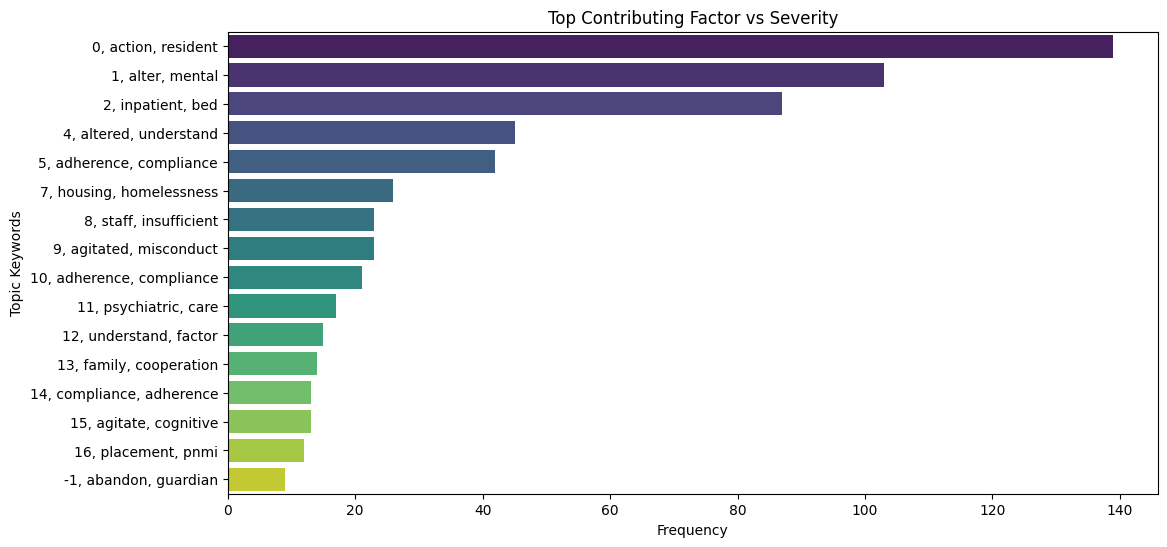

In [178]:
# Map topics to keywords
topic_keywords = topic_info.set_index("Topic")["Name"].str.split("_").str[:3].str.join(", ")
df_clean["topic_label"] = df_clean["topic"].map(topic_keywords)

# Plot
plt.figure(figsize=(12, 6))
topic_counts = df_clean["topic_label"].value_counts().reset_index()
sns.barplot(x="count", y="topic_label", data=topic_counts, palette="viridis")
plt.title("Top Contributing Factor vs Severity")
plt.xlabel("Frequency")
plt.ylabel("Topic Keywords")
plt.show()

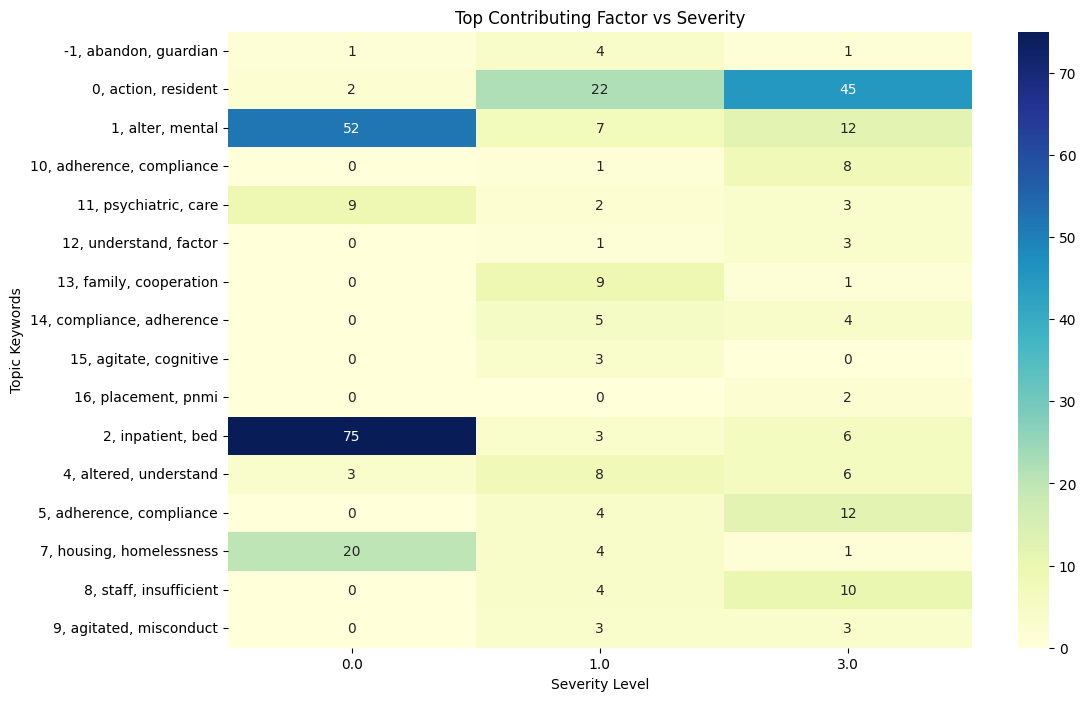

In [179]:
topic_severity = pd.crosstab(df_clean["topic_label"], df_clean["severity"])

plt.figure(figsize=(12, 8))
sns.heatmap(topic_severity, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Top Contributing Factor vs Severity")
plt.xlabel("Severity Level")
plt.ylabel("Topic Keywords")
plt.show()

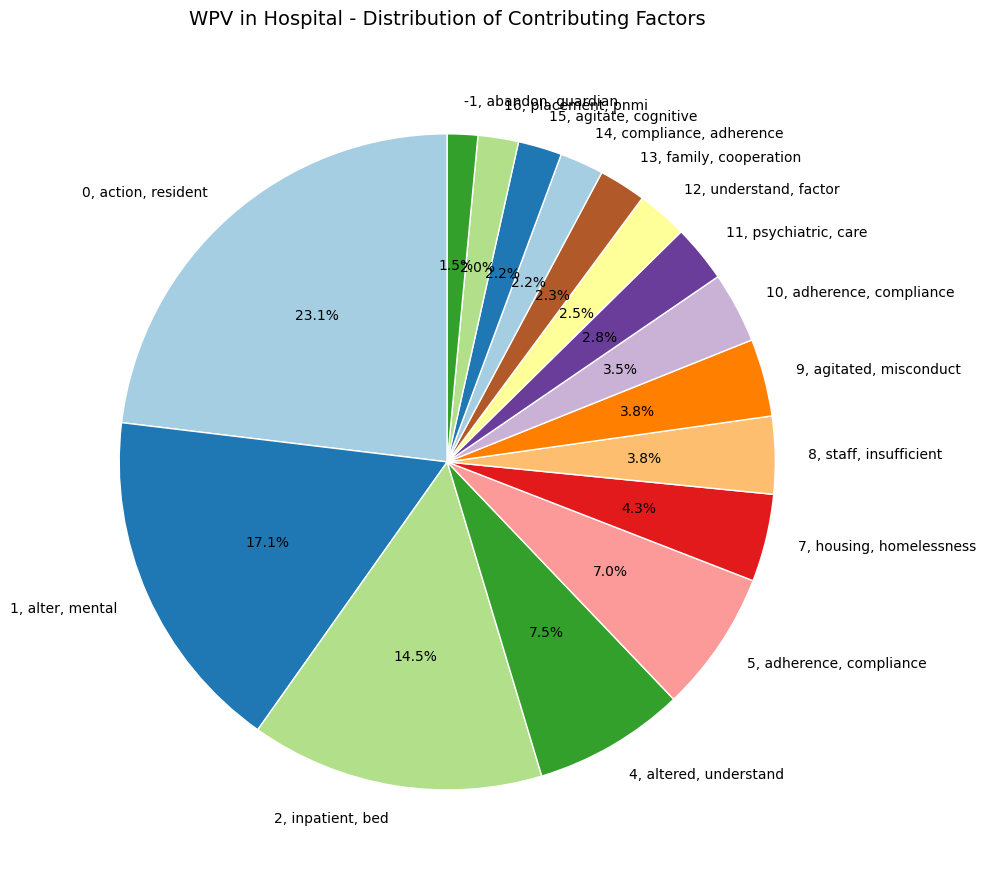

In [182]:
# Get cleaned topic counts (exclude outliers and garbage)
topic_counts = df_clean["topic_label"].value_counts().reset_index()
topic_counts.columns = ["topic_keywords", "count"]

# Optional: Group rare topics into "Other" if too many slices
threshold = 5  # Minimum count to keep as a separate slice
major_topics = topic_counts[topic_counts["count"] >= threshold]
minor_topics = topic_counts[topic_counts["count"] < threshold]

# Combine minor topics into "Other"
if len(minor_topics) > 0:
    other_row = pd.DataFrame({
        "topic_keywords": ["Other"],
        "count": [minor_topics["count"].sum()]
    })
    topic_counts = pd.concat([major_topics, other_row])

plt.figure(figsize=(10, 10))

# Define colors (avoid red/green for colorblind accessibility)
colors = plt.cm.Paired.colors[:len(topic_counts)]

# Plot
plt.pie(
    topic_counts["count"],
    labels=topic_counts["topic_keywords"],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1},
    textprops={"fontsize": 10}
)

# Add title and adjust layout
plt.title("WPV in Hospital - Distribution of Contributing Factors", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

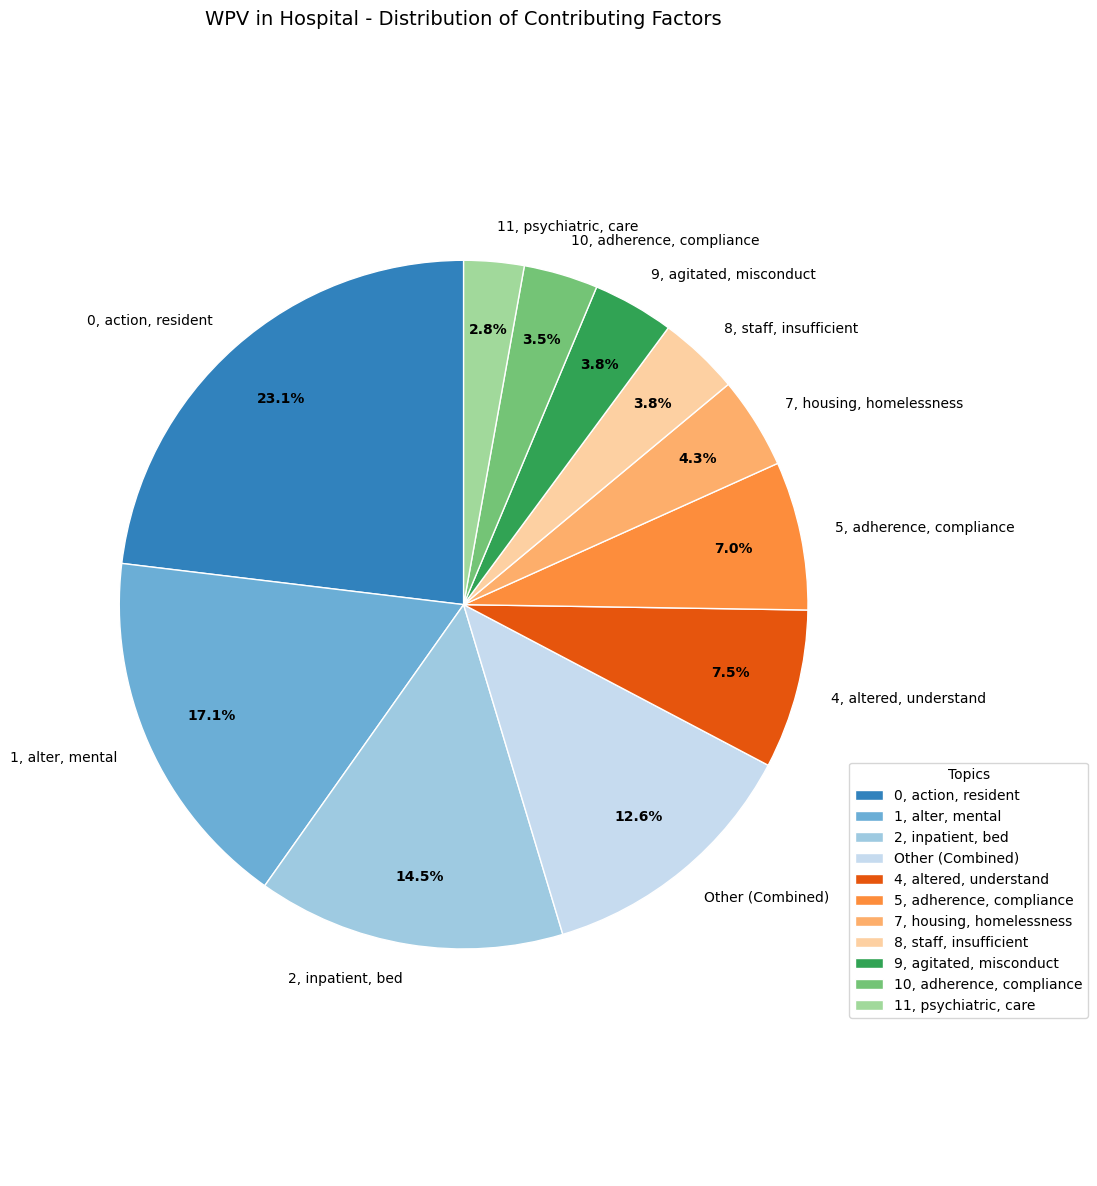

In [195]:
# Get topic counts
topic_counts = df_clean["topic_label"].value_counts().reset_index()
topic_counts.columns = ["topic_keywords", "count"]

# Calculate percentages
topic_counts["percentage"] = (topic_counts["count"] / topic_counts["count"].sum()) * 100

# Group topics <2.5% into "Other"
major_topics = topic_counts[topic_counts["percentage"] >= 2.5]
minor_topics = topic_counts[topic_counts["percentage"] < 2.5]

if len(minor_topics) > 0:
    other_row = pd.DataFrame({
        "topic_keywords": ["Other (Combined)"],
        "count": [minor_topics["count"].sum()],
        "percentage": [minor_topics["percentage"].sum()]
    })
    topic_counts = pd.concat([major_topics, other_row])

# Sort by count (largest first)
topic_counts = topic_counts.sort_values("count", ascending=False)

plt.figure(figsize=(12, 12))

# Custom colors (avoid red/green)
colors = plt.cm.tab20c.colors[:len(topic_counts)]

# Plot with improved settings
wedges, texts, autotexts = plt.pie(
    topic_counts["count"],
    labels=topic_counts["topic_keywords"],
    autopct=lambda p: f"{p:.1f}%" if p >= 2.5 else "",  # Hide labels for tiny slices
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1},
    textprops={"fontsize": 10},
    pctdistance=0.8  # Move percentages inside slices
)

# Adjust label positions to prevent overlap
plt.setp(autotexts, size=10, weight="bold", color="black")
plt.setp(texts, size=10)

# Equal aspect ratio ensures the pie is circular
plt.axis("equal")

# Add legend for "Other" if present
if "Other (Combined)" in topic_counts["topic_keywords"].values:
    plt.legend(
        wedges,
        topic_counts["topic_keywords"],
        title="Topics",
        loc="center left",
        bbox_to_anchor=(1, 0.25),
        fontsize=10
    )

plt.title("WPV in Hospital - Distribution of Contributing Factors", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(right=0.7)
plt.show()

##### Semantic Continue Here

In [203]:
df = pd.read_csv('8_9.5_all_necessary_only_add.moon.temp.des.csv')

###### Factor

In [205]:
# Download stopwords if not already done
nltk.download('stopwords')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

# 1. Clean the factor column
df["factor"] = df["factor"].fillna("")  # Replace NaN with empty strings
df = df[~df["factor"].str.contains(r"^[,\s]+$", regex=True)]  # Remove rows with only commas/spaces
df = df[df["factor"].str.strip().str.len() > 3]  # Keep rows with meaningful text (>3 characters)

# 2. Text cleaning function
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text).lower())  # Remove punctuation
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]  # Added length filter
    return " ".join(tokens)

df["factor_clean"] = df["factor"].apply(clean_text)

# 3. Train BERTopic
topic_model = BERTopic(language="english", min_topic_size=10)
topics, _ = topic_model.fit_transform(df["factor_clean"])

# Store topics in a new column (don't overwrite factor_clean)
df["topic"] = topics

# 4. Get topic info and filter garbage topics
topic_info = topic_model.get_topic_info()  # Need to actually get the topic info

# Identify garbage topics (more robust filtering)
garbage_topics = topic_info[
    topic_info["Name"].str.contains("__|unknown|,|^[\W\d]+$", regex=True) |
    (topic_info["Count"] < 10)  # Also filter very small topics
]["Topic"].tolist()

# 5. Filter out garbage topics
df_clean = df[~df["topic"].isin(garbage_topics)].copy()

# 6. Create topic labels (more robust handling)
def create_topic_label(row):
    if pd.isna(row["topic"]):
        return "Other"
    topic_num = int(row["topic"])
    if topic_num == -1:
        return "Outliers"
    keywords = topic_model.get_topic(topic_num)
    if keywords:
        return ", ".join([word for word, _ in keywords[:3]])
    return f"Topic {topic_num}"

df_clean["topic_label"] = df_clean.apply(create_topic_label, axis=1)

# 7. Final cleanup - group rare topics
topic_counts = df_clean["topic_label"].value_counts()
rare_topics = topic_counts[topic_counts < 5].index
df_clean["topic_label"] = df_clean["topic_label"].apply(
    lambda x: "Other" if x in rare_topics else x
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [207]:
# df.head()
df_clean.head()

,aggressor,role,violence type,location,general location,severity,emotion,care,factor,description,...,day,day_of_week,is_weekend,Moon Phase,Full Moon,Precipitation,Temperature,factor_clean,topic,topic_label
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,9,1,0,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack"
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,9,1,0,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack"
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,9,1,0,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack"
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,9,1,0,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,alter mental status inpatient bed unavailable,grab pinching scratch hair pull kicking hit be...,...,6,1,0,0.865656,0,0.0,31.55,alter mental status inpatient bed unavailable,11,"psychiatric, guardian, abandon"


###### Description

In [208]:
df = df_clean
df.head()

,aggressor,role,violence type,location,general location,severity,emotion,care,factor,description,...,day,day_of_week,is_weekend,Moon Phase,Full Moon,Precipitation,Temperature,factor_clean,topic,topic_label
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,9,1,0,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack"
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,9,1,0,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack"
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,9,1,0,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack"
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,9,1,0,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,alter mental status inpatient bed unavailable,grab pinching scratch hair pull kicking hit be...,...,6,1,0,0.865656,0,0.0,31.55,alter mental status inpatient bed unavailable,11,"psychiatric, guardian, abandon"


In [209]:
# 1. Clean the description column
df["description"] = df["description"].fillna("")  # Handle missing values
df = df[~df["description"].str.contains(r"^[,\s]+$", regex=True)]  # Remove empty/whitespace-only
df = df[df["description"].str.strip().str.len() > 3]  # Keep meaningful text

# 2. Clean text (same function as before)
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text).lower())
    tokens = [word for word in text.split()
             if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

df["desc_clean"] = df["description"].apply(clean_text)

# 3. Train BERTopic on descriptions
desc_model = BERTopic(language="english", min_topic_size=10)
desc_topics, _ = desc_model.fit_transform(df["desc_clean"])
df["desc_topic"] = desc_topics

# 4. Get topic info and filter garbage
desc_topic_info = desc_model.get_topic_info()
desc_garbage_topics = desc_topic_info[
    desc_topic_info["Name"].str.contains("__|unknown|,|^[\W\d]+$", regex=True) |
    (desc_topic_info["Count"] < 10)
]["Topic"].tolist()

df_clean_desc = df[~df["desc_topic"].isin(desc_garbage_topics)].copy()

# 5. Create topic labels
def create_desc_topic_label(topic_num):
    if topic_num == -1:
        return "Outliers"
    keywords = desc_model.get_topic(topic_num)
    return ", ".join([word for word, _ in keywords[:3]])

df_clean_desc["desc_topic_label"] = df_clean_desc["desc_topic"].apply(create_desc_topic_label)

# 6. Group rare description topics
desc_topic_counts = df_clean_desc["desc_topic_label"].value_counts()
rare_desc_topics = desc_topic_counts[desc_topic_counts < 5].index
df_clean_desc["desc_topic_label"] = df_clean_desc["desc_topic_label"].apply(
    lambda x: "Other" if x in rare_desc_topics else x
)

In [223]:
df_clean_desc.head()

,aggressor,role,violence type,location,general location,severity,emotion,care,factor,description,...,Moon Phase,Full Moon,Precipitation,Temperature,factor_clean,topic,topic_label,desc_clean,desc_topic,desc_topic_label
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack",verbal assault push shoving harassment head bu...,6,"verbal, assault, harassment"
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack",verbal assault push shoving harassment head bu...,6,"verbal, assault, harassment"
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack",verbal assault push shoving harassment head bu...,6,"verbal, assault, harassment"
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack",verbal assault push shoving harassment head bu...,6,"verbal, assault, harassment"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,alter mental status inpatient bed unavailable,grab pinching scratch hair pull kicking hit be...,...,0.865656,0,0.0,31.55,alter mental status inpatient bed unavailable,11,"psychiatric, guardian, abandon",grab pinching scratch hair pull kicking hit be...,5,"verbal, pinching, hair"


In [224]:
df = df_clean_desc

In [225]:
df.head()

,aggressor,role,violence type,location,general location,severity,emotion,care,factor,description,...,Moon Phase,Full Moon,Precipitation,Temperature,factor_clean,topic,topic_label,desc_clean,desc_topic,desc_topic_label
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack",verbal assault push shoving harassment head bu...,6,"verbal, assault, harassment"
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack",verbal assault push shoving harassment head bu...,6,"verbal, assault, harassment"
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack",verbal assault push shoving harassment head bu...,6,"verbal, assault, harassment"
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,...,0.915367,1,8.3,25.50,homelessness lack housing,6,"housing, homelessness, lack",verbal assault push shoving harassment head bu...,6,"verbal, assault, harassment"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,alter mental status inpatient bed unavailable,grab pinching scratch hair pull kicking hit be...,...,0.865656,0,0.0,31.55,alter mental status inpatient bed unavailable,11,"psychiatric, guardian, abandon",grab pinching scratch hair pull kicking hit be...,5,"verbal, pinching, hair"


In [226]:
df.to_csv('8_9.6_all_vector_factor.desc.csv', index=False)

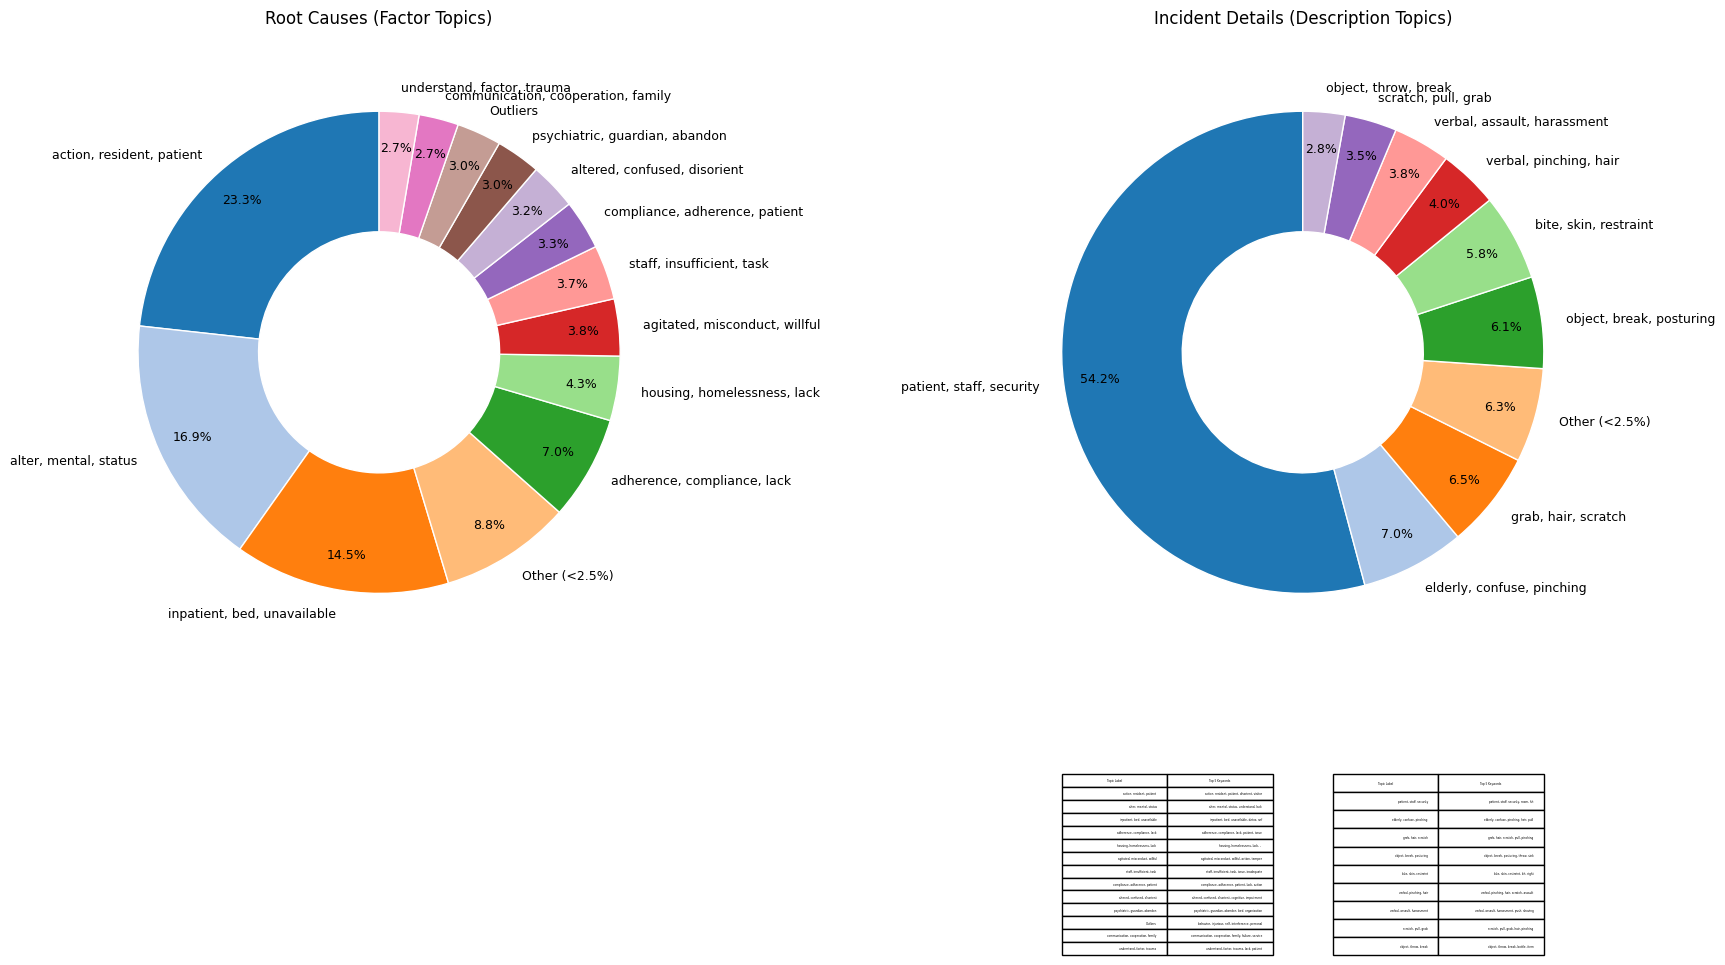

In [215]:
# 1. Function to group small topics
def group_small_topics(df, topic_col, threshold=0.025):
    topic_counts = df[topic_col].value_counts(normalize=True)
    major_topics = topic_counts[topic_counts >= threshold].index
    df[topic_col] = df[topic_col].apply(lambda x: x if x in major_topics else "Other (<2.5%)")
    return df

# Apply to both factor and description topics
df_clean = group_small_topics(df_clean, "topic_label")
df_clean_desc = group_small_topics(df_clean_desc, "desc_topic_label")

# 2. Create exploded pie charts with annotations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# Custom colors
colors = plt.cm.tab20.colors

# Factor topics pie
factor_counts = df_clean["topic_label"].value_counts()
wedges1, texts1, autotexts1 = ax1.pie(
    factor_counts,
    labels=factor_counts.index,
    autopct=lambda p: f"{p:.1f}%" if p >= 2.5 else "",
    startangle=90,
    colors=colors,
    wedgeprops={"width": 0.5, "edgecolor": "white"},
    pctdistance=0.85,
    textprops={"fontsize": 9}
)
ax1.set_title("Root Causes (Factor Topics)", pad=20)

# Description topics pie
desc_counts = df_clean_desc["desc_topic_label"].value_counts()
wedges2, texts2, autotexts2 = ax2.pie(
    desc_counts,
    labels=desc_counts.index,
    autopct=lambda p: f"{p:.1f}%" if p >= 2.5 else "",
    startangle=90,
    colors=colors,
    wedgeprops={"width": 0.5, "edgecolor": "white"},
    pctdistance=0.85,
    textprops={"fontsize": 9}
)
ax2.set_title("Incident Details (Description Topics)", pad=20)

# 3. Add interactive legend (hover functionality)
def hover(event):
    for i, (wedge, text) in enumerate(zip(wedges1, texts1)):
        if wedge.contains(event)[0]:
            text.set_fontweight("bold")
            text.set_fontsize(11)
        else:
            text.set_fontweight("normal")
            text.set_fontsize(9)
    fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

# 4. Add table with full topic details
factor_table_data = []
for topic in factor_counts.index:
    if topic != "Other (<2.5%)":
        keywords = topic_model.get_topic(int(df_clean[df_clean["topic_label"]==topic]["topic"].iloc[0]))
        factor_table_data.append([topic, ", ".join([w[0] for w in keywords[:5]])])

desc_table_data = []
for topic in desc_counts.index:
    if topic != "Other (<2.5%)":
        keywords = desc_model.get_topic(int(df_clean_desc[df_clean_desc["desc_topic_label"]==topic]["desc_topic"].iloc[0]))
        desc_table_data.append([topic, ", ".join([w[0] for w in keywords[:5]])])

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)

# Add factor topic details
factor_table = plt.table(
    cellText=factor_table_data,
    colLabels=["Topic Label", "Top 5 Keywords"],
    loc="bottom",
    bbox=[0.1, -0.5, 0.35, 0.3]
)

# Add description topic details
desc_table = plt.table(
    cellText=desc_table_data,
    colLabels=["Topic Label", "Top 5 Keywords"],
    loc="bottom",
    bbox=[0.55, -0.5, 0.35, 0.3]
)

plt.show()

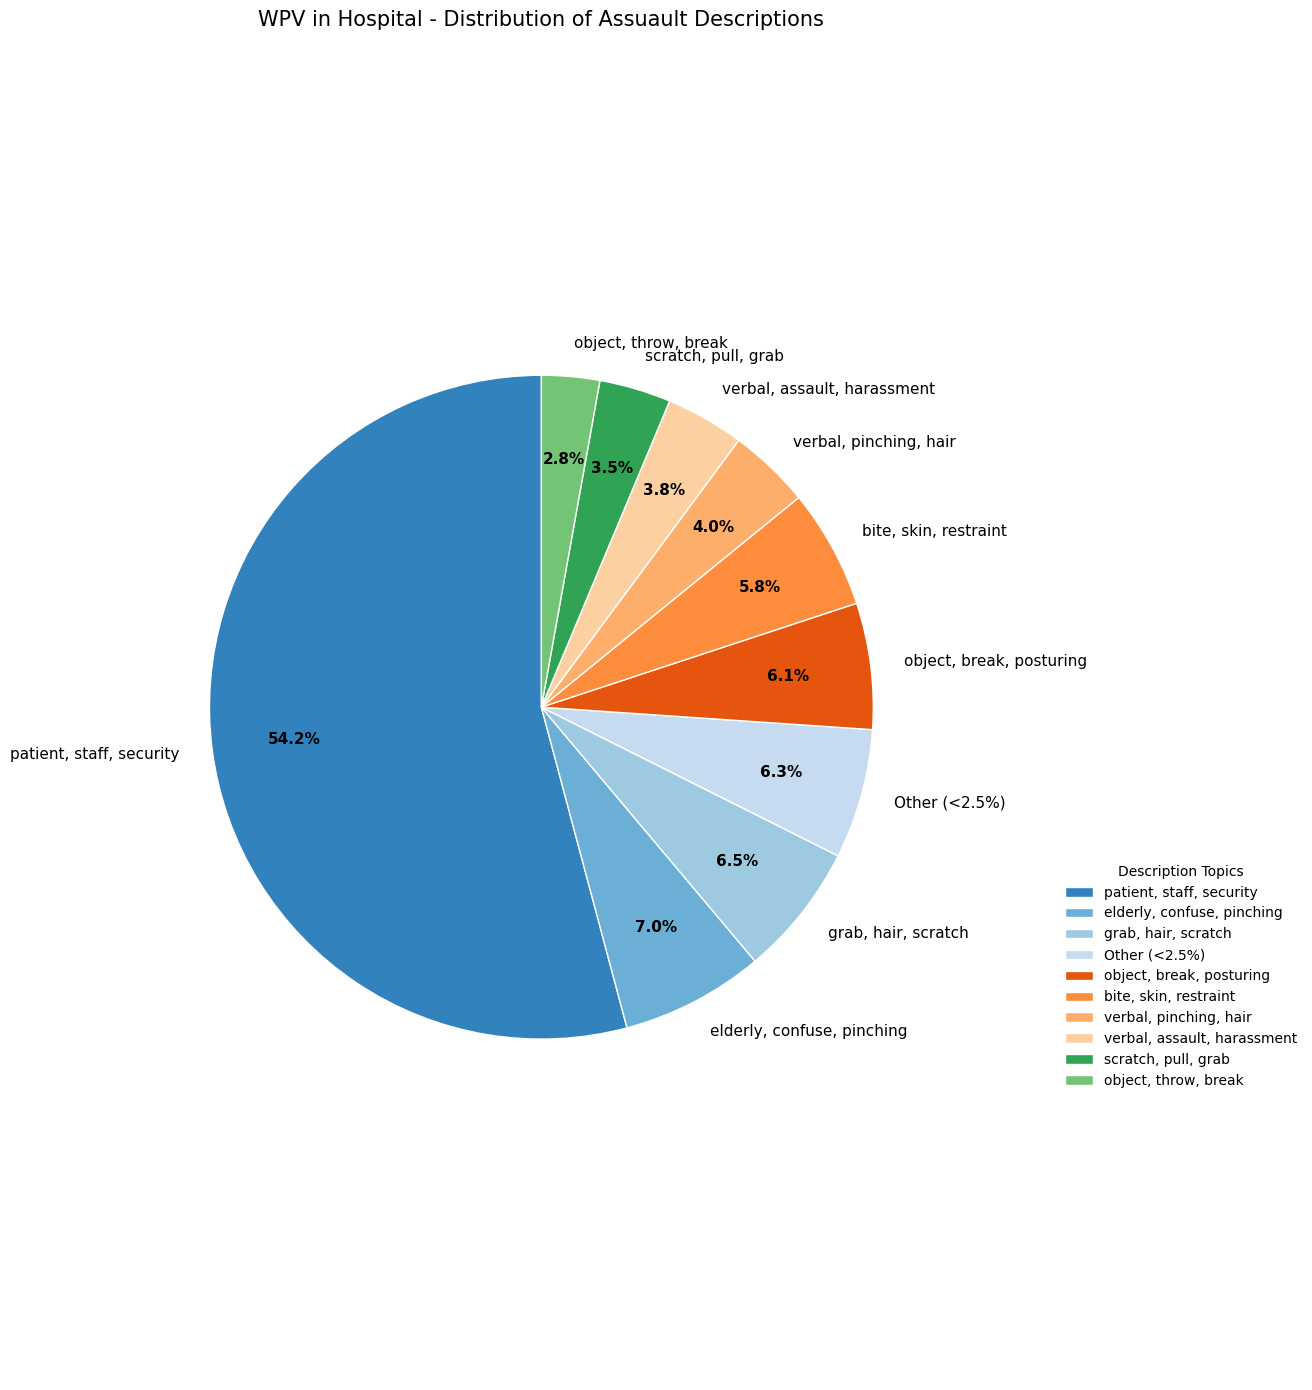

In [227]:
# 1. Prepare description topic data
desc_topic_counts = df_clean_desc["desc_topic_label"].value_counts().reset_index()
desc_topic_counts.columns = ["topic_keywords", "count"]
desc_topic_counts["percentage"] = (desc_topic_counts["count"] / desc_topic_counts["count"].sum()) * 100

# 2. Group small topics (<2.5%) into "Other"
major_desc_topics = desc_topic_counts[desc_topic_counts["percentage"] >= 2.5]
minor_desc_topics = desc_topic_counts[desc_topic_counts["percentage"] < 2.5]

if len(minor_desc_topics) > 0:
    other_row = pd.DataFrame({
        "topic_keywords": ["Other (Combined)"],
        "count": [minor_desc_topics["count"].sum()],
        "percentage": [minor_desc_topics["percentage"].sum()]
    })
    desc_topic_counts = pd.concat([major_desc_topics, other_row])

# 3. Sort by count
desc_topic_counts = desc_topic_counts.sort_values("count", ascending=False)

# 4. Create the pie chart
plt.figure(figsize=(14, 14))

# Custom color palette
colors = plt.cm.tab20c.colors[:len(desc_topic_counts)]

# Plot with clean formatting
wedges, texts, autotexts = plt.pie(
    desc_topic_counts["count"],
    labels=desc_topic_counts["topic_keywords"],
    autopct=lambda p: f"{p:.1f}%" if p >= 2.5 else "",
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1},
    textprops={"fontsize": 11},
    pctdistance=0.75
)

# 5. Improve label readability
plt.setp(autotexts, size=11, weight="bold", color="black")
plt.setp(texts, size=11)

# 6. Add comprehensive legend
plt.legend(
    wedges,
    desc_topic_counts["topic_keywords"],
    title="Description Topics",
    loc="center left",
    bbox_to_anchor=(1.2, 0.3),
    fontsize=10,
    frameon=False
)

# 7. Final formatting
plt.title("WPV in Hospital - Distribution of Assuault Descriptions",
          fontsize=15)
plt.axis("equal")
plt.tight_layout()
plt.subplots_adjust(right=0.65)  # Make space for legend
plt.show()

In [229]:
df.drop('factor', axis=1, inplace=True)
df.drop('description', axis=1, inplace=True)
df.drop('factor_clean', axis=1, inplace=True)
df.drop('desc_clean', axis=1, inplace=True)

In [231]:
df.to_csv('8_9.7_all_clean_vector_factor.desc.csv', index=False)

In [230]:
df.head()

,aggressor,role,violence type,location,general location,severity,emotion,care,response,month,...,day_of_week,is_weekend,Moon Phase,Full Moon,Precipitation,Temperature,topic,topic_label,desc_topic,desc_topic_label
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,"Security Called, Law Enforcement Called, De-es...",1,...,1,0,0.915367,1,8.3,25.50,6,"housing, homelessness, lack",6,"verbal, assault, harassment"
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,"Security Called, Law Enforcement Called, De-es...",1,...,1,0,0.915367,1,8.3,25.50,6,"housing, homelessness, lack",6,"verbal, assault, harassment"
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,"Security Called, Law Enforcement Called, De-es...",1,...,1,0,0.915367,1,8.3,25.50,6,"housing, homelessness, lack",6,"verbal, assault, harassment"
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,"Security Called, Law Enforcement Called, De-es...",1,...,1,0,0.915367,1,8.3,25.50,6,"housing, homelessness, lack",6,"verbal, assault, harassment"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"Security Called, Law Enforcement Called, Physi...",2,...,1,0,0.865656,0,0.0,31.55,11,"psychiatric, guardian, abandon",5,"verbal, pinching, hair"


#### ignore below

In [147]:
# Preprocess text data
text_data = df["factor"].fillna("")

# Train BERTopic model
topic_model = BERTopic(language="english", calculate_probabilities=True)
topics, probabilities = topic_model.fit_transform(text_data)

# Assign topics back to the dataframe
df["Topic"] = topics

# Extract topic-keyword distributions
topic_info = topic_model.get_topic_info()

# Visualize topics
topic_model.visualize_topics()
topic_model.visualize_barchart(top_n_topics=10)

In [143]:
# Preprocess text data
text_data = df["description"].fillna("")

# Train BERTopic model
topic_model = BERTopic(language="english", calculate_probabilities=True)
topics, probabilities = topic_model.fit_transform(text_data)

# Assign topics back to the dataframe
df["Topic"] = topics

# Extract topic-keyword distributions
topic_info = topic_model.get_topic_info()

# Visualize topics
topic_model.visualize_topics()
topic_model.visualize_barchart(top_n_topics=10)

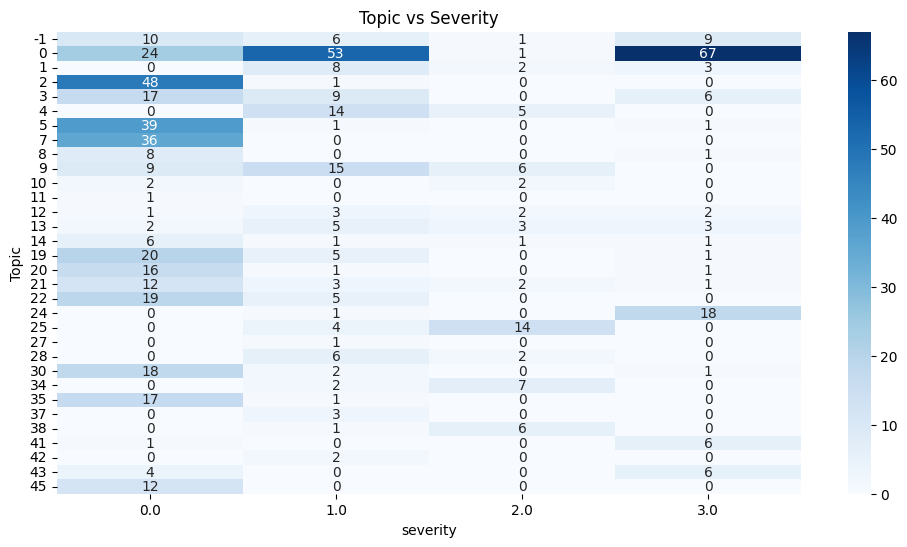

In [145]:
# Cross-tabulate topics with severity/emotional scores
topic_severity = pd.crosstab(df["Topic"], df["severity"])
topic_emotion = pd.crosstab(df["Topic"], df["emotion"])

# Plot heatmaps
plt.figure(figsize=(12, 6))
sns.heatmap(topic_severity, annot=True, cmap="Blues")
plt.title("Topic vs Severity")
plt.show()

## Sentiment/Emotion Analysis

In [34]:
# Initialize sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Analyze sentiment for each description
df["Sentiment"] = df["description"].apply(lambda x: sentiment_analyzer(x[:512])[0]["label"])

# Cross-validate with emotional impact scores
sentiment_emotion = pd.crosstab(df["Sentiment"], df["emotion"])

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


## Entity and Role Extraction

In [35]:
nlp = spacy.load("en_core_web_sm")

# Extract entities from descriptions
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

df["Entities"] = df["description"].apply(extract_entities)

# Check role consistency (example)
def check_role_consistency(row):
    entities = row["Entities"]
    roles = [row["role"], row["aggressor"]]
    return any(role in entities for role in roles)

df["Role_Consistency"] = df.apply(check_role_consistency, axis=1)

In [36]:
df.head()

,date,aggressor,response,role,violence type,location,general location,severity,emotion,care,factor,description,Topic,Sentiment,Entities,Role_Consistency
0,1/9/2024,Patient,"Security Called, Law Enforcement Called, De-es...",Nurse,Physical Violence,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,24,NEGATIVE,[],False
1,1/9/2024,Patient,"Security Called, Law Enforcement Called, De-es...",Nurse,Verbal Abuse,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,24,NEGATIVE,[],False
2,1/9/2024,Patient,"Security Called, Law Enforcement Called, De-es...",Nurse,Physical Violence,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,24,NEGATIVE,[],False
3,1/9/2024,Patient,"Security Called, Law Enforcement Called, De-es...",Nurse,Verbal Abuse,ED/ER,Clinical Unit,1.0,1.0,NaN,homelessness lack housing,verbal assault push shoving harassment head bu...,24,NEGATIVE,[],False
4,2/6/2024,Patient,"Security Called, Law Enforcement Called, Physi...",Nurse,Physical Violence,ED/ER,Clinical Unit,0.0,0.0,NaN,alter mental status inpatient bed unavailable,grab pinching scratch hair pull kicking hit be...,26,NEGATIVE,[],False


## Feature Engineering for ML

In [37]:
# Encode categorical variables
df = pd.get_dummies(df, columns=["role", "aggressor", "violence type"])

# Combine structured and NLP features
features = pd.concat([
    df[["severity", "emotion", "care"]],
    pd.get_dummies(df["Topic"], prefix="Topic"),
    pd.get_dummies(df["Sentiment"], prefix="Sentiment")
], axis=1)

# Define target variable (e.g., predict severity)
X = features.drop("severity", axis=1)
y = features["severity"]

## Train ML Predictive Models

In [45]:
mask = ~np.isnan(y)
X_clean = X[mask]
y_clean = y[mask]

# Option 2: If classification, you could also impute with the most frequent class
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='most_frequent')
# y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

y_clean

,severity
0,1.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
1577,1.0
1585,2.0
1597,2.0
1612,3.0


              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90        68
         1.0       0.57      0.46      0.51        28
         2.0       0.86      0.43      0.57        14
         3.0       0.89      0.77      0.83        22

    accuracy                           0.79       132
   macro avg       0.78      0.67      0.70       132
weighted avg       0.78      0.79      0.77       132



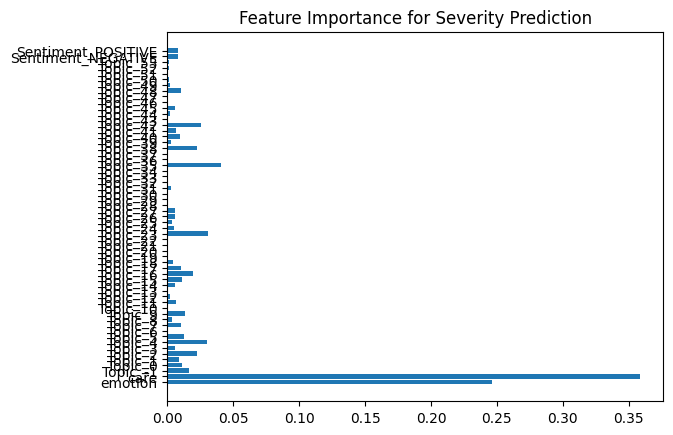

In [43]:
# Split the cleaned data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance
plt.barh(X.columns, clf.feature_importances_)
plt.title("Feature Importance for Severity Prediction")
plt.show()

## Temporal and Spatial Analysis

## Map to number